In [1]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!cp -r /content/gdrive/'My Drive'/train.zip .

In [3]:
from zipfile import ZipFile

with ZipFile("train.zip", 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#!pip install tensorflow==1.15.2
import tensorflow
print(tensorflow.__version__)

In [ ]:
import pandas as pd
from glob import glob
import os
from PIL import Image
import tensorflow
import numpy as np
import time
import random
import pathlib
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(34)

resnet = ResNet50(weights='imagenet')

In [ ]:
def read_dataset(path, size_batch, num_batch):
    X = []
    y = []
    image_paths_list = glob(os.path.join(path, 'train', '*.jpg'))
    for i in tqdm(range(num_batch)):
      #choose 1000 random samples and then throw out selected images from image_paths_list
      image_paths_sample = random.sample(image_paths_list, size_batch)
      image_paths_list = list(set(image_paths_list) - set(image_paths_sample))
      for image_path in image_paths_sample:
          image_name = os.path.basename(image_path)
          image_name_parts = image_name.split('.')
          label = image_name_parts[0] if len(image_name_parts) == 3 else None

          if label:
              y.append(int(label == 'cat'))
          
          #use resnet and get X
          x = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          resnet_feature = resnet.predict(x)
          resnet_feature_np = np.array(resnet_feature)
          #print(resnet_feature_np.shape)
          X.append(resnet_feature_np.flatten())
                
    return np.array(X), y

In [ ]:
features, labels = read_dataset('', 500, 6) #path='data/' 
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
print(x_train.shape)

In [ ]:
%%time
clf = xgb.XGBClassifier()
clf.fit(x_train, y_train)

score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test)
#get 98.1-98.5 on test with standard parametres

n_estimators=200: 0.9989 0.9870 time: 3min 12s

n_estimators=150: 0.997 0.98653 time: 2min 21s - остановился на таком кол-ве, по крайней мере пока подбираю learning_rate.

learning_rate=0.01: 0.979 0.9761 time: 2min 31s

learning_rate=0.2: 1.0 0.986 time: 2min 20s

learning_rate=0.3: 1.0 0.98773 time: 2min 19s - неплохое значение, дальше уже явный оверфит начинается, из-за чего скор на тесте падает при скоре на трейне в 1.0. Ради интереса попробовал n_estimators=200, learning_rate = 0.3: 1.0 0.987733 time: 2min 58s.



In [ ]:
%%time
clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3)
clf.fit(x_train, y_train)

score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test)

1.0 0.9873333333333333
CPU times: user 2min 55s, sys: 39.4 ms, total: 2min 55s
Wall time: 2min 55s


In [ ]:
from hyperopt import hp, tpe, Trials, STATUS_OK, fmin
from sklearn.metrics import roc_auc_score

SEED = 314159265

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dtest,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    space = {
        'n_estimators': 200,
        'learning_rate': 0.3,
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    best = fmin(score, space, algo=tpe.suggest, max_evals=15)
    return best

best_hyperparams = optimize()
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

The best hyperparameters are:  

{'colsample_bytree': 0.9500000000000001, 'gamma': 0.6000000000000001, 'max_depth': 3, 'min_child_weight': 2.0, 'subsample': 0.8500000000000001}

1.0 0.987733 time: 2min 51s С этими параметрами. Не очень сильно увеличился скор :( Что-то не так сделал, или тут уже разумно просто ставить больше n_estimators? Решил не менять с 200, точность вроде бы и так нормальная.

In [ ]:
%%time
clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3, colsample_bytree=0.9500000000000001, gamma=0.6000000000000001, max_depth=3, min_child_weight=2.0, subsample=0.8500000000000001)
clf.fit(x_train, y_train)

score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test)

1.0 0.9811111111111112
CPU times: user 12.2 s, sys: 125 ms, total: 12.3 s
Wall time: 13 s


n=85, Accuracy: 0.98111
CPU times: user 1.16 s, sys: 9.99 ms, total: 1.17 s
Wall time: 1.3 s


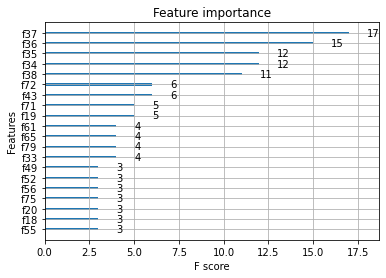

In [ ]:
%%time
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance

selection = SelectFromModel(clf, threshold=0.001, prefit=True)
select_x_train = selection.transform(x_train)

selection_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3, colsample_bytree=0.9500000000000001, gamma=0.6000000000000001, max_depth=3, min_child_weight=2.0, subsample=0.8500000000000001)
selection_model.fit(select_x_train, y_train)

select_x_test = selection.transform(x_test)
y_pred = selection_model.predict(select_x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("n=%d, Accuracy: %.5f" % (select_x_train.shape[1], accuracy))

plot_importance(selection_model, max_num_features=20)